In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Multi-label prediction with Planet Amazon Data Set**

In [0]:
from fastai.vision import *

In [0]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.5)


In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhedya","key":"12c5d6574799604e8ae88fb78fbf097b"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [0]:
!sudo apt install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  

100% 599M/600M [00:13<00:00, 40.5MB/s]
100% 600M/600M [00:13<00:00, 46.9MB/s]


In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 46.6MB/s]


In [0]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05,
                     max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg',
                          suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128).databunch().normalize(imagenet_stats))

In [0]:
data.c

17

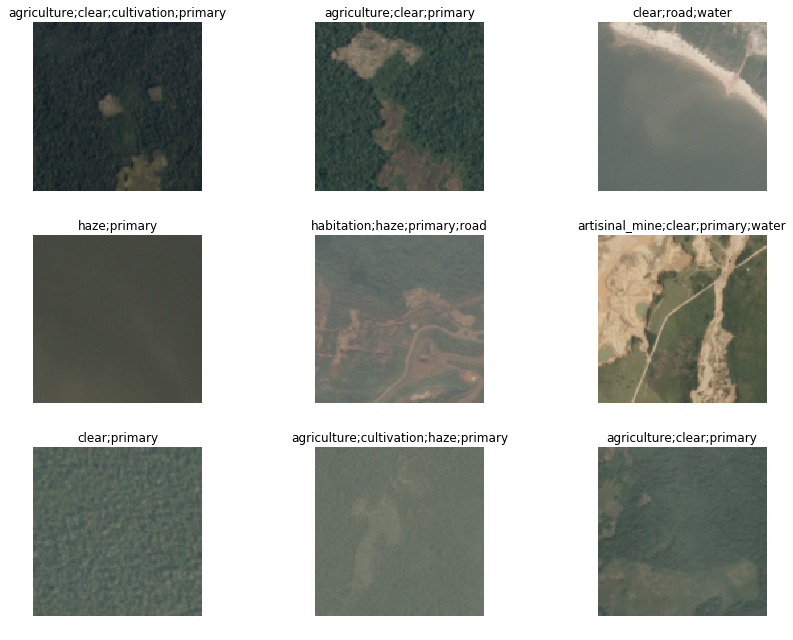

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 95202187.97it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

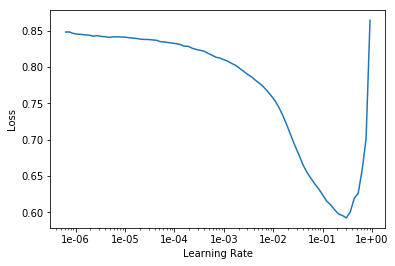

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [0]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.124300,0.109321,0.941133,0.904619,02:50
1,0.109909,0.099363,0.950209,0.913469,02:41
2,0.100418,0.091859,0.950325,0.921602,02:38
3,0.097069,0.088700,0.956858,0.923336,02:36
4,0.090161,0.086977,0.956327,0.925449,02:35


In [0]:
learn.save('stage1-res50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


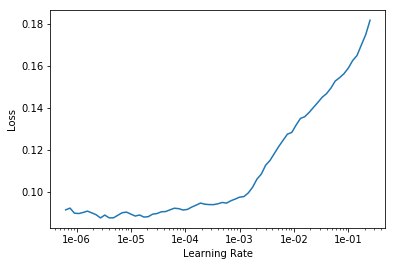

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.100424,0.091247,0.952469,0.919024,02:45
1,0.096558,0.090417,0.957599,0.921809,02:44
2,0.091567,0.086076,0.957286,0.925201,02:44
3,0.085847,0.082659,0.958413,0.928702,02:43
4,0.080488,0.082750,0.957803,0.928047,02:43


In [0]:
learn.save('stage2-res50')

In [0]:
data.c

17

In [0]:
data = (src.transform(tfms, size=256)
       .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


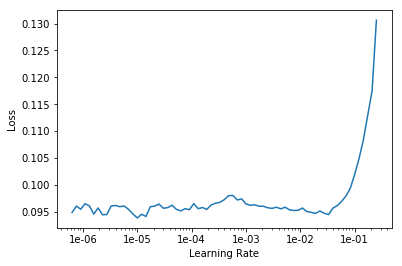

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2/2

In [0]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.088735,0.085577,0.955107,0.925495,05:37
1,0.087182,0.083971,0.959241,0.928793,05:25
2,0.084140,0.082797,0.957970,0.927665,05:20
3,0.080241,0.081292,0.958660,0.929799,05:16
4,0.082162,0.081271,0.959903,0.930969,05:15


In [0]:
learn.save('stage1-256-res50')

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(5, slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091794,0.091490,0.953086,0.921955,07:03
1,0.092862,0.087117,0.954482,0.925201,07:01
2,0.088511,0.085335,0.956502,0.925638,07:01
3,0.081911,0.081742,0.958769,0.930364,07:01
4,0.080903,0.080823,0.959321,0.930773,07:02


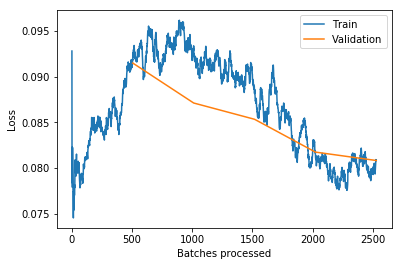

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.save('finalstage-256-res50')

In [0]:
!ls

kaggle.json  sample_data


In [0]:
learn.export()

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

 98% 593M/603M [00:08<00:00, 82.2MB/s]
100% 603M/603M [00:09<00:00, 70.1MB/s]
 93% 281M/304M [00:07<00:00, 31.8MB/s]
100% 304M/304M [00:07<00:00, 44.0MB/s]


In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [0]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

['clear primary',
 'clear primary road selective_logging',
 'agriculture clear cultivation primary road',
 'clear primary',
 'agriculture conventional_mine habitation partly_cloudy primary road']

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)


In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

100% 2.20M/2.20M [00:06<00:00, 363kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space

In [0]:
files.download(path/'submission.csv')